# Adaptive PDE discretizations on cartesian grids
## Volume : Divergence form PDEs
## Part : Applications
## Chapter : Extracting geodesics from the heat kernel

This notebook is a numerical illustration of *Varadhan's formula*, which relates Riemannian geodesics and eikonal equations, with the heat kernel.
We also present a variant of this method, devoted to Rander metrics, which are asymmetric perturbations of Riemannian metrics featuring a drift term.

**References**

The numerical scheme used for anisotropic diffusion in this notebook is taken from:
* Fehrenbach, J., & Mirebeau, J.-M. (2014). Sparse non-negative stencils for anisotropic diffusion. Journal of Mathematical Imaging and Vision, 49(1), 123–147. http://doi.org/http://dx.doi.org/10.1007/s10851-013-0446-3

The Varadhan formula was first numerically illustrated in:
* Crane, K., Weischedel, C., & Wardetzky, M. (2013). Geodesics in heat: A new approach to computing distance based on heat flow. ACM Transactions on Graphics (TOG), 32(5), 152.

## Anisotropic diffusion and Riemannian distances : Varadhan's formula

**An elliptic equation.** 
Let $\Omega \subset R^d$ be a domain, and let $D : \Omega \to S_d^{++}$ be a field of diffusion tensors. 
Consider the elliptic optimization problem 
$$
    \min \int_\Omega \epsilon^2 | \nabla u(x)|^2_{D(x)} + u(x)^2\, dx
$$
subject to Dirichlet boundary conditions on a part $\Gamma_D \subset \partial \Omega$ of the domain boundary 
$$
    u=1 \text{ on } \Gamma_D,
$$
and Neuman boundary conditions on $\partial\Omega \setminus \Gamma_D$. 
In the interior of the domain, the above optimization problem can be rephrase in the form of an elliptic partial differential equation
$$
    u(x) - \epsilon^2 \mathrm{div} (D(x) \nabla u(x)) = 0.
$$

**Relation with the eikonal equation.**
Denote by $u_\epsilon$ the solution.
Under adequate assumptions, one can show that 
$$
    v_\epsilon := -\epsilon \ln u_\epsilon
$$
converges as $\epsilon \to 0^+$ to the distance function from $\Gamma_D$ on $\Omega$, measured with respect to the metric $M(x) := D(x)^{-1}$ which is the inverse to the diffusion tensors. 
A justification for this fact is that the PDE
$$
    |\nabla v(x)|_{D(x)}^2 - \epsilon \mathrm{div}( D(x) \nabla v(x)) = 1
$$
is satisfied on $\Omega$, along with the Dirichlet boundary condition $v=0$ on $\Gamma_D$.
As $\epsilon \to 0$, the viscosity introduced by the second order operator vanishes, and one recovers the eikonal equation $|\nabla v(x)|_{D(x)} = 1$.

**Interpretation as a path length.**
Consider the Riemannian metric 
$$
    M(x) := D(x)^{-1},
$$
for all $x \in \Omega$.
Let us recall that the unique viscosity solution to the above eikonal equation, with Dirichlet boundary conditions on $\Gamma_D$ and outflow boundary conditions on $\partial \Omega \setminus \Gamma_D$, is the distance map from $\Gamma_D$:
$$
    v(x) = \inf_\gamma \int_0^1 \| \gamma'(t)\|_{M(\gamma(t))} dt
$$
where $\gamma : [0,1] \to \Omega$ has locally Lipschitz regularity, and is subject to the constraints:
$$
    \gamma(0) \in \Gamma_D, \quad \gamma(1) = x.
$$
The minimal geodesics $\gamma$ can also be recovered, by a gradient flow method.

### Remarks on Varadhan's formula
**Optional refinement.**
Crane et al suggest a simple additional non-linear step to improve the accuracy of the reconstructed distance map $v$. While interesting, this method is not discussed in this notebook. 
Note also that this extra-step is:
- incompatible with the Sinkhorn algorithm, discussed in the next notebook.
- regarded as un-necessary if one is interested in the minimal geodesic paths rather than the geodesic distance itself.

**Non-divergence form variant.**
A non-divergence form equation can be considered, instead of the above divergence form elliptic equation:
$$
    u(x) - \epsilon^2 \mathrm{tr} (D(x) \nabla^2 u(x)) = 0,
$$
for all $x \in \Omega$. This modification has little impact on the results, since the introduced first order term is negligible. See the end of this notebook for the introduction of a non-negligible first order term, in the context of Rander metrics.

**Parabolic (time dependent) variant.**
Another variant of Varadhan's formula involves following the parabolic equation
$$
    \partial_t u(t,x) - \mathrm{div} (D(x) \nabla u(t,x)).
$$
It is discussed in the next notebook, in relation with Sinkhorn's algorithm.

[**Summary**](Summary.ipynb) of volume Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Isotropic metrics](#1.-Isotropic-metrics)
    * [1.1 Reproducing the Euclidean distance](#1.1-Reproducing-the-Euclidean-distance)
    * [1.2 Effect of the relaxation parameter $\epsilon$](#1.2-Effect-of-the-relaxation-parameter-$\epsilon$)
    * [1.3 The Poincare half plane model](#1.3-The-Poincare-half-plane-model)
  * [2. Anisotropic Riemannian metrics](#2.-Anisotropic-Riemannian-metrics)
    * [2.1 Geodesic distance on a surface](#2.1-Geodesic-distance-on-a-surface)
    * [2.2 Metric definition in term of eigenvectors and eigenvalues](#2.2-Metric-definition-in-term-of-eigenvectors-and-eigenvalues)
  * [3. Rander metrics](#3.-Rander-metrics)
    * [3.1 Generalized Varadhan formula](#3.1-Generalized-Varadhan-formula)
    * [3.2 Constant Rander metric](#3.2-Constant-Rander-metric)
    * [3.3 Zermelo's problem with a variable drift](#3.3-Zermelo's-problem-with-a-variable-drift)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans, 
and PhD student François Desquilbet, in co-direction with Ludovic Métivier.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; TocTools.displayTOC('VaradhanGeodesics','Div')

In [2]:
from agd import LinearParallel as lp
from agd import LinearPDE

In [3]:
import numpy as np
import scipy.linalg; import scipy.sparse; import scipy.sparse.linalg 
from matplotlib import pyplot as plt

Some utility functions

In [4]:
def RangeIndex(rg,x):
    """Find the index of a value x in an equispaced range rg"""
    return int(round( (x-rg[0])/(rg[-1]-rg[0]) * (len(rg)-1)))

def streamplot_ij(X,Y,VX,VY,subsampling=1,*varargs,**kwargs):
    def f(array): return array[::subsampling,::subsampling].T # Transpose and subsample
    return plt.streamplot(f(X),f(Y),f(VX),f(VY),*varargs,**kwargs) 

## 1. Isotropic metrics

We illustrate Varadhan's formula for isotropic metrics, which are locally proportionnal to the Euclidean metric.
$$
    M(x) = c(x)^2 \mathrm{Id},
$$
where $c : \Omega \to ]0,\infty[$ is a continuous and positive cost function.
The length of a path $\gamma : [0,1] \to \Omega$, w.r.t. this metric, is therefore
$$
    \int_0^1 c(\gamma(t)) \|\gamma(t)\| dt,
$$
and the eikonal equation reads
$$
    \| \nabla v(x)\| = c(x),
$$
for all $x \in \Omega$.

Varadhan's method involves, for this application, solving the elliptic equation
$$
    u(x) - \varepsilon^2 \mathrm{div}( c(x)^{-2} \nabla u(x)) = 0.
$$

**Discretization.** Since the laplacian operator is *isotropic*, i.e. it is defined in terms of an isotropic diffusion tensor $c(x)^{-2} \mathrm{Id}$, the standard five point finite difference scheme is used.


**Geodesic extraction.** Minimal geodesics obtained by following the gradient of the distance map. In other words by solving the ordinary differential equation
$$
    \gamma'(t) = V(\gamma(t)),
$$
backwards in time, where for all $x \in \Omega$
$$
    V(x) = \nabla u(x).
$$

### 1.1 Reproducing the Euclidean distance

We compute the Euclidean distance from three points, referred to as *seeds*, in the square domain $[0,1]^2$.
This test can be regarded as a sanity check. The Euclidean metric is obtained by choosing the constant cost $c\equiv 1$ in the above definition of a Riemannian metric.

In [5]:
#Define the domain [0,1]^2, sampled on a cartesian grid
gridScale = 0.02
aX = np.arange(0,1,gridScale); aY = aX
X,Y = np.meshgrid(aX,aY,indexing='ij')
bounds=X.shape

# Generate the diffusion tensors (inverse to the metric tensors)
diff = lp.identity(bounds)
# dim=2; diff = np.zeros((dim,dim)+bounds); diff[0,0]=1; diff[1,1]=1 # Equivalent definition

# Generate the scalar term
mult = np.full(bounds,1.)

# Choose the seeds from which distance is computed
seeds = [[0.3,0.2],[0.8,0.3],[0.5,0.8]] # multiple seeds
#seeds = [[0.5,0.5]] #Alternatively : single seed in the center

# Set the relaxation parameter
epsilon = 2 * gridScale

The following function computes an approximate Riemannian distance using Varadhan's formula.
Note that, Neumann boundary conditions are imposed on the square boundary.

In [6]:
def RiemannianDistance0(diff,rhs,gridScale,epsilon,omega=None):
    """Approximate a Riemannian distance using Varadhan's formula"""
    # Omega is a first order term, to be used later in the context of Rander metrics
    
    # Generate the scalar term
    bounds = diff.shape[2:]
    mult = np.full(bounds,1.) 
    
    # Generate the operator matrix
    coef,(row,col) = LinearPDE.OperatorMatrix(epsilon**2 * diff,
    mult=mult,omega=omega,gridScale=gridScale,boundaryConditions='Neumann')
    laplacian = scipy.sparse.coo_matrix((coef,(row,col))).tocsr()

    # Solve
    solution = scipy.sparse.linalg.spsolve(laplacian,rhs.flatten()).reshape(bounds)
    
    # Extract Riemannian distance
    distance = -epsilon*np.log(solution)
    
    return distance-np.min(distance)

Rather than imposing Dirichlet boundary conditions at the seed points, we introduce of a non-zero right hand side, featuring Dirac-like singularities.

In [7]:
def MakeRHS(seeds,axes):
    rhs=np.full(tuple(len(ax) for ax in axes),0.)
    for seed in seeds:
        rhs[tuple(RangeIndex(ax,x) for ax,x in zip(axes,seed))] = 1
    return rhs

In [8]:
rhs = MakeRHS(seeds,(aX,aY))

In [9]:
distance = RiemannianDistance0(diff,rhs,gridScale,epsilon)

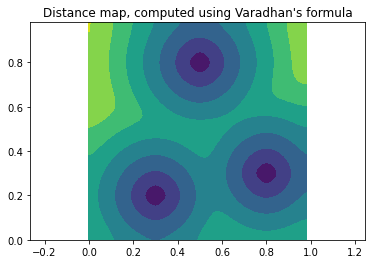

In [10]:
plt.axis('equal'); plt.title("Distance map, computed using Varadhan's formula")
plt.contourf(X,Y,distance);

In [11]:
def streamplot_ij(X,Y,VX,VY,*varargs,**kwargs):
    return plt.streamplot(X.T,Y.T,VX.T,VY.T,*varargs,**kwargs) # Transpose everything

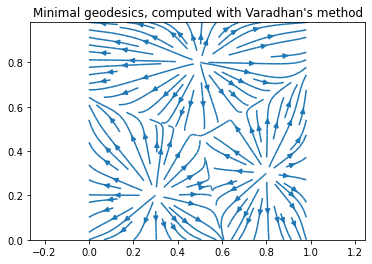

In [12]:
gX,gY = np.gradient(distance,gridScale)
plt.axis('equal'); plt.title("Minimal geodesics, computed with Varadhan's method")
streamplot_ij(X,Y,gX,gY);

### 1.2 Effect of the relaxation parameter $\epsilon$


The convergence analysis requires that the gridscale $h$ vanishes faster than the relaxation parameter $\epsilon$:
$$
    h,\epsilon \to 0 \quad \text{ and } \quad \epsilon/h \to +\infty.
$$

In practice, best results are obtained when the relaxation parameter $\epsilon$ is a few times larger than the gridscale $h$. In the above example, we set 
$$
    \epsilon = 2 h
$$
which is a reasonable choice. Beware however that:
* An excessively small $\epsilon/h$ leads to a non-convergent distance.
* An excessively large $\epsilon/h$ produces undesirable numerical diffusion.

In [13]:
# Setting a too low value of epsilon
distance = RiemannianDistance0(diff,rhs,gridScale,epsilon/10)

The $L^1$ distance is (approximately) reproduced, instead of the desired euclidean distance, because $\epsilon$ is too small.

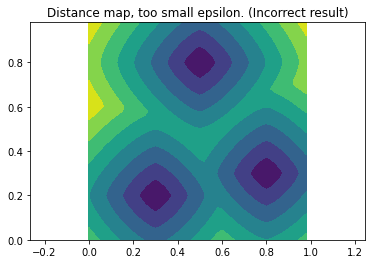

In [14]:
plt.axis('equal'); plt.title("Distance map, too small epsilon. (Incorrect result)")
plt.contourf(X,Y,distance);

In [15]:
# Setting a too large value of epsilon
distance = RiemannianDistance0(diff,rhs,gridScale,epsilon*10)

The level sets are not equidistant, because $\epsilon$ is too large.

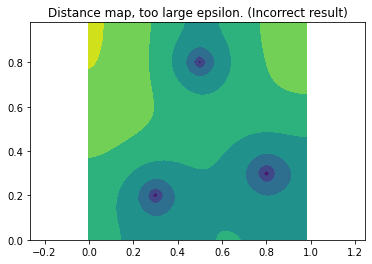

In [16]:
plt.axis('equal'); plt.title("Distance map, too large epsilon. (Incorrect result)")
plt.contourf(X,Y,distance);

### 1.3 The Poincare half plane model

We illustrate Varadhan's formula on the Poincare model of the half plane, which is one of the geometric instantiations of the hyperbolic plane. (The Poincare disk model is another such well known instantiation.)

The Poincare half plane model is posed on the domain $\Omega = \mathbb R \times \mathbb R_+^*$, which is equipped with the following Riemannian metric
$$
    \frac{dx^2 + dy^2} {y^2},
$$
for all $x,y \in \Omega$. Note that the metric is again isotropic.
This numerical example is solved with an alternative method in 
[III - The Fisher information metric](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/B4_FisherRao.ipynb)

**Automatic parameter setting.**
The `RiemannianDistance0` method coded above is not much practical since it requires to:
- manually inverse the Riemannian metric tensors $M$, in order to produce the diffusion tensors $D(x) := M(x)^{-1}$.
- manually select an adequate relaxation parameter $\epsilon$.

In the following cell, we automate this process.

In [17]:
def diffScale(D):
    """Associates a length scale (upper bound) with a field of diffusion tensors"""
    return np.sqrt(np.max(lp.trace(D)))

def RiemannianDistance(metric,rhs,gridScale):
    diff = lp.inverse(metric)
    epsilon = diffScale(diff) * 2 * gridScale
    return RiemannianDistance0(diff,rhs,gridScale,epsilon)

We next set up the Poincare half plane example.

In [18]:
# Create the domain [-1,1] x [0.3,1.3]
gridScale = 0.01
aX = np.arange(-1,1,gridScale)
aY = np.arange(0.3,1.3,gridScale)
X,Y = np.meshgrid(aX,aY,indexing='ij')
bounds = X.shape

seeds = [[0,0.5]]

# Define the Riemannian metric
metric = np.full((2,2)+bounds,0.)
metric[0,0] = 1/Y**2
metric[1,1] = 1/Y**2

In [19]:
rhs = MakeRHS(seeds, (aX,aY))

In [20]:
distance = RiemannianDistance(metric,rhs,gridScale)

Level sets of the Poincare distance are (non concentric) Euclidean disks.

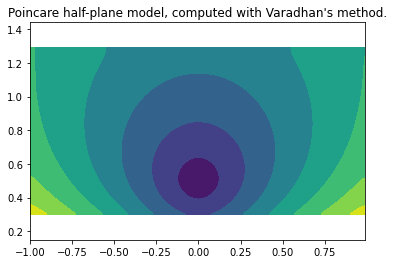

In [21]:
plt.axis('equal'); plt.title("Poincare half-plane model, computed with Varadhan's method.")
plt.contourf(X,Y,distance);

Geodesics of the Poincare metric are Euclidean cirles.

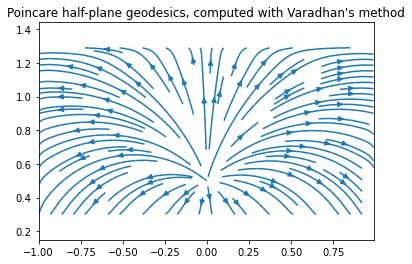

In [22]:
plt.axis('equal'); plt.title("Poincare half-plane geodesics, computed with Varadhan's method")
streamplot_ij(X,Y,*np.gradient(distance));

## 2. Anisotropic Riemannian metrics

Varadhan's formula applies to both isotropic and anisotropic Riemannian metrics. Numerically, the main difficulty in the anisotropic context is to discretize an anisotropic Laplacian. This point is transparently handled by the provided routine, using technologies described in 
[I Tensor decomposition, dimensions 2 and 3](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/TensorSelling.ipynb)

Once the geodesic distance $v$ from a given point is computed, geodesic backtracking relies similar to the isotropic case on an ODE
$$
    \gamma'(t) = V(\gamma(t)),
$$
where the flow direction is defined as the intrinsic gradient of the distance map
$$
    V(x) = D(x) \nabla v(x).
$$
The following numerical examples are solved with an alternative numerical method in 
[II - Riemannian metrics](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A3_Riemannian.ipynb)

### 2.1 Geodesic distance on a surface

We compute the geodesic distance on a parametrized two dimensional surface embedded into $R^3$ and defined by a height map:
$$
    z(x,y) = (3/4) sin(3 \pi  x) sin(3 \pi y), 
$$
where $(x,y) \in ]-0.5,0.5[^2$. The metric is 
$$
    M(x,y) = \mathrm{Id} + \nabla z(x,y) \nabla z(x,y)^T.
$$

In [23]:
# Create the domain
gridScale = 0.01
aX = np.arange(-0.5,0.5,gridScale); aY=aX;
X,Y = np.meshgrid(aX,aY,indexing='ij')
bounds=X.shape

# Define the metric
Z = (3/4.)*np.sin(3*np.pi*X)*np.sin(3*np.pi*Y)
grad = np.array(np.gradient(Z,gridScale))
metric = lp.identity(bounds) + lp.outer_self(grad) 

# Generate the rhs
rhs = MakeRHS([[0.,0.]], (aX,aY))

In [24]:
distance = RiemannianDistance(metric,rhs,gridScale)

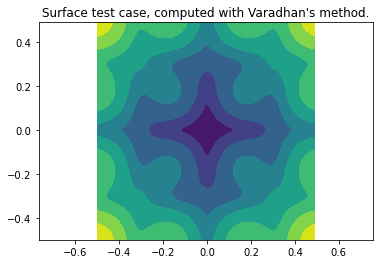

In [25]:
plt.axis('equal'); plt.title("Surface test case, computed with Varadhan's method.")
plt.contourf(X,Y,distance);

In [26]:
flow = lp.solve_AV(metric,np.array(np.gradient(distance)))

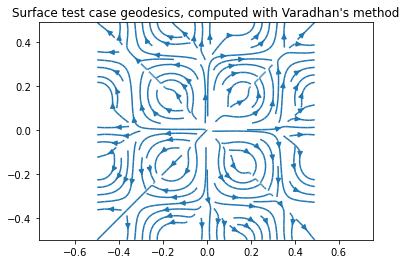

In [27]:
plt.axis('equal'); plt.title("Surface test case geodesics, computed with Varadhan's method")
streamplot_ij(X,Y,*flow);

### 2.2 Metric definition in term of eigenvectors and eigenvalues

In this example, the metric tensors are specified by their eigenvectors and eigenvalues
$$
    M(x) = \lambda_1(x)^{-2} v_1(x) v_1(x)^T + \lambda_2(x)^{-2} v_2(x) v_2(x)^T.
$$
The scalars $\lambda_1$ and $\lambda_2$ appearing in this expression should be regarded as the local velocity in the direction of $v_1$ and $v_2$ respectively.

Our specific example involves constant eigenvalues, defined by $\lambda_1 \equiv 0.8$ and $\lambda_2( \equiv 0.2$, and an analytic eigenvector $v_1(x_1,x_2) \propto (1, \cos( 2 \pi x_1))$ (normalized) while $v_2$ is orthogonal.

In [28]:
# Create the domain
gridScale = 0.02
aX = np.arange(-1,1,gridScale); aY=aX;
X,Y = np.meshgrid(aX,aY,indexing='ij')
bounds=X.shape

# Generate the metric
eig1 = np.stack((np.full(bounds,1.),(np.pi/2)*np.cos(2*np.pi*X)))
eig1 /= scipy.linalg.norm(eig1,axis=0) 
eig2 = np.stack( (eig1[1],-eig1[0]) )
lambda1, lambda2 = 0.8, 0.2
metric = lambda1**-2*lp.outer_self(eig1) + lambda2**-2*lp.outer_self(eig2)

# Generate the rhs
rhs = MakeRHS([[0.,0.]], (aX,aY))

In [29]:
distance = RiemannianDistance(metric,rhs,gridScale)

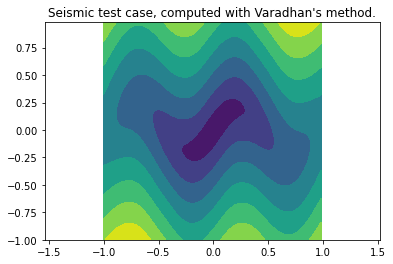

In [30]:
plt.axis('equal'); plt.title("Seismic test case, computed with Varadhan's method.")
plt.contourf(X,Y,distance);

In [31]:
flow = lp.solve_AV(metric,np.array(np.gradient(distance)))

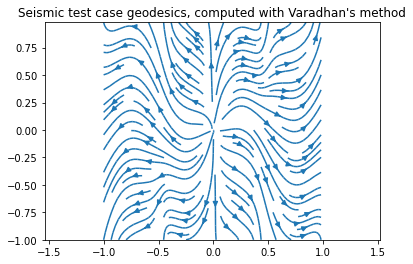

In [32]:
plt.axis('equal'); plt.title("Seismic test case geodesics, computed with Varadhan's method")
streamplot_ij(X,Y,*flow);

## 3. Rander metrics

**Optimal control viewpoint.**
Rander metric are an extension of Riemannian metrics featuring a drift term. We choose to illustrate them through an optimal control problem, referred to as Zermelo's navigation problem:
find the shortest time $T$ for which there exists a path $\gamma : [0,T] \to \Omega$ obeying 
$$
    \|\gamma'(t) - \omega(\gamma(t)) \|_{M(t)} \leq 1
$$
for all $t \in [0,T]$, subject to the boundary conditions $\gamma(0) \in \Gamma_D$ and $\gamma(T) = x$ is a specified point of the domain.

The problem parameters are the Riemannian metric $M$, the drift vector field $\omega$, and the source set $\Gamma_D$. We make the further assumption that 
$$
    \| \omega(x) \|_{M(x)} < 1
$$
for all $x \in \Omega$, otherwise the problem is not locally controllable.

**The eikonal equation.** The arrival time $v(x) := T$ for the above optimal control problem obeys the generalized eikonal PDE
$$
    \| \nabla v(x)\|_{D(x)} + <\omega(x), \nabla v(x)> = 1,
$$
where $D(x) := M(x)^{-1}$ is the inverse of the Riemannian metric.

**Geodesic backtracking.** Minimal paths are extracted by an *intrinsic* gradient descent, taking into account the geometry defined by the Rander metric. The ODE thus takes the form $\gamma'(t) = V(\gamma(t))$ where
$$
    V(x) := \frac{D(x) \nabla v(x)}{\|\nabla v(x)\|_{D(x)}} + \omega(x).
$$

### 3.1 Generalized Varadhan formula

Consider the elliptic equation
$$
    u + 2\epsilon <\omega,\nabla u> - \epsilon^2 \mathrm{div}(A \nabla u)=0,
$$
where $A$ is a field of positive definite matrices, in a domain $\Omega$. 
Assume e.g. $u=1$ on the boundary $\partial \Omega$.
Then setting $u = e^{-v/\epsilon}$, we find that $v$ obeys the PDE
$$
    \|\nabla v\|_A^2 - \epsilon \mathrm{div}(A \nabla v) = 1 + 2 <\omega, \nabla v>.
$$
Adding $<\omega, \nabla v>^2$ to both sides of this equation we obtain
$$
    \| \nabla v\|_D^2 - \epsilon \mathrm{div}(A \nabla v) = (1 + <\omega, \nabla v>)^2,
$$
where we set $D := A+\omega\omega^T$ and factored the r.h.s.
Neglecting the viscosity induced by the second order term, which vanishes as $\epsilon \to 0$, taking the square root and rearranging terms we obtain 
$$
    \| \nabla v\|_D - <\omega,\nabla v> =1,
$$
which is the generalized eikonal equation for Rander metrics.

**Numerical scheme.**
The second order term $\mathrm{div}(A \nabla u)$ is discretized as in the Riemannian case, relying on the techniques of 
[I Tensor decomposition, dimensions 2 and 3](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/TensorSelling.ipynb)

The first order term $2 <\omega,\nabla u>$ is discretized using centered finite differences, in the same direction as the second order differences discretizing the second order term. The resulting discretization is second order consistent, and monotone under adequate assumptions, see below.


**Relaxation parameter.**
The relaxation parameter $\epsilon$ is subject to an additional constraint in the case of Rander metrics.
Indeed, if $\epsilon$ is too small, then the first order term dominates the second order term in Varadhan's formula, and the numerical scheme looses monotony. The resulting numerical solution may in that case present negative values, and the method fails. 

The method presented below involves a relaxation parameter only slightly larger than in the Riemannian case, which is already enough to accomodate fairly strong drifts, see below. Automatic setting of the relaxation parameter for even stronger drifts will be the object ot future research.

In [33]:
def RanderDistance(metric,drift,rhs,gridScale):
    diff = lp.inverse(metric)
    epsilon = diffScale(diff) * 3 * gridScale
    distance = RiemannianDistance0(diff-lp.outer_self(drift),rhs,gridScale,epsilon,
                               omega=2*epsilon*drift)
    grad = np.array(np.gradient(distance,gridScale))
    flow = lp.dot_AV(diff,grad)
    flow = flow/np.sqrt(lp.dot_VV(flow,grad)) + drift
    return distance, flow

### 3.2 Constant Rander metric

This example is a sanity check, involving a constant Riemannian metric, namely the Euclidean metric, and a constant drift field in the direction of $(1,1)/\sqrt 2$.
As a result:
- The level sets of the distance map are (non-concentric) circles.
- The minimal geodesic paths a straight lines toward the origin.

In [34]:
# Define the domain
gridScale = 0.02
aX = np.arange(-1,1,gridScale); aY=aX;
X,Y = np.meshgrid(aX,aY,indexing='ij')
bounds=X.shape

# Define the Riemannian metric and the drift
drift = 0.7 * np.ones((2,)+bounds)/np.sqrt(2)
metric = lp.identity(bounds)

# Set the rhs
rhs = MakeRHS([[0,0]],(aX,aY))

In [35]:
distance,flow = RanderDistance(metric,drift,rhs,gridScale)

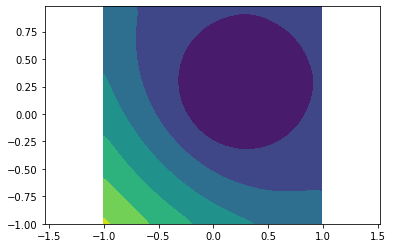

In [36]:
plt.axis('equal');
plt.contourf(X,Y,distance);

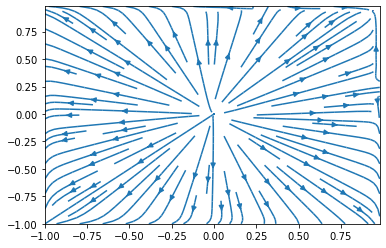

In [37]:
streamplot_ij(X,Y,*flow);

### 3.3 Zermelo's problem with a variable drift

We present an instance of Zermelo's navigation problem, where the vehicle's maximum speed is unit in all directions, but it is subject to a position dependent drift, with the analytical expression:
$$
    \omega(x,y) := \rho \sin(2 \pi x) \sin (2 \pi y) \frac{(x,y)}{\|(x,y)\|},
$$
for all $x,y \in [-1,1]^2$. Note that the metric positiveness constraint requires $|\rho| < 1$. We let $\rho := 0.8$.

A different numerical approach for the same problem is presented in the notebook
[III - Rander metrics. Application to Zermelo's navigation problem, and image segmentation](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A6_Rander.ipynb)

In [38]:
drift = 0.8*np.sin(2*np.pi*X)*np.sin(2*np.pi*Y) * np.stack((X,Y))/ np.sqrt(X**2+Y**2)

In [39]:
distance,flow = RanderDistance(metric,drift,rhs,gridScale)

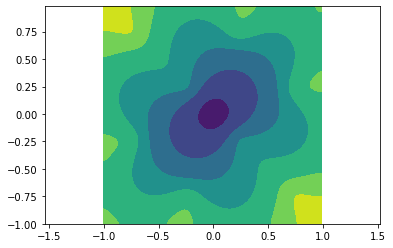

In [40]:
plt.axis('equal');
plt.contourf(X,Y,distance);

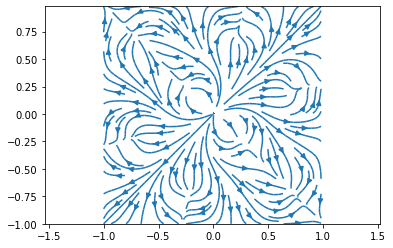

In [41]:
plt.axis('equal')
streamplot_ij(X,Y,*flow);